In [121]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

import pathlib
import IPython.display as display
import os
import random

2.0.0-alpha0


# Load images with tf.data

In [136]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Path containing the images to train
# They should be organized like: <root_dir>/<class name>/<image name.extension>
IMAGES_PATH = '../../image_gathering/imgs'
data_root = pathlib.Path(IMAGES_PATH)
print(data_root)

../../image_gathering/imgs


In [137]:
# Get list of image paths
if not data_root.exists():
    raise

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

tmp = "\n".join(all_image_paths[:3])
print(f'Example image paths:\n{tmp}\n(...)')

image_count = len(all_image_paths)
print(f'Number of images: {image_count}')

Example image paths:
../../image_gathering/imgs/ethernet/imx6.png
../../image_gathering/imgs/ethernet/im631.png
../../image_gathering/imgs/ethernet/im164.png
(...)
Number of images: 1056


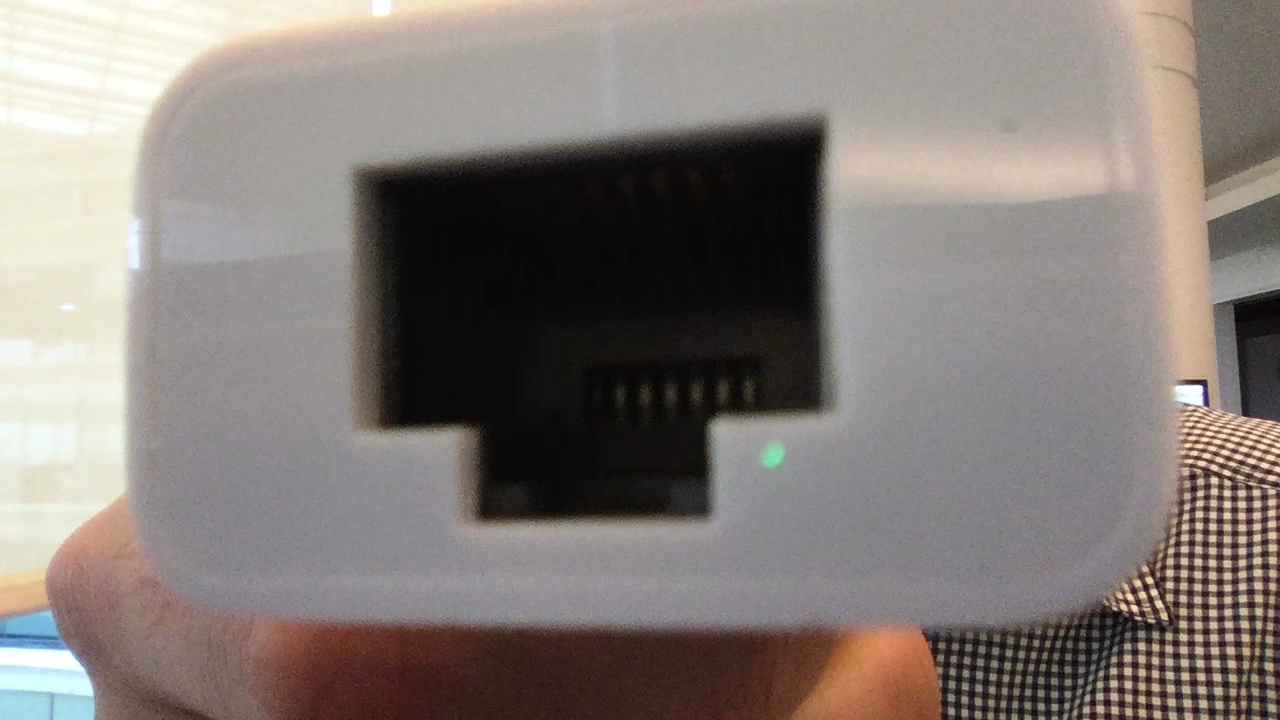

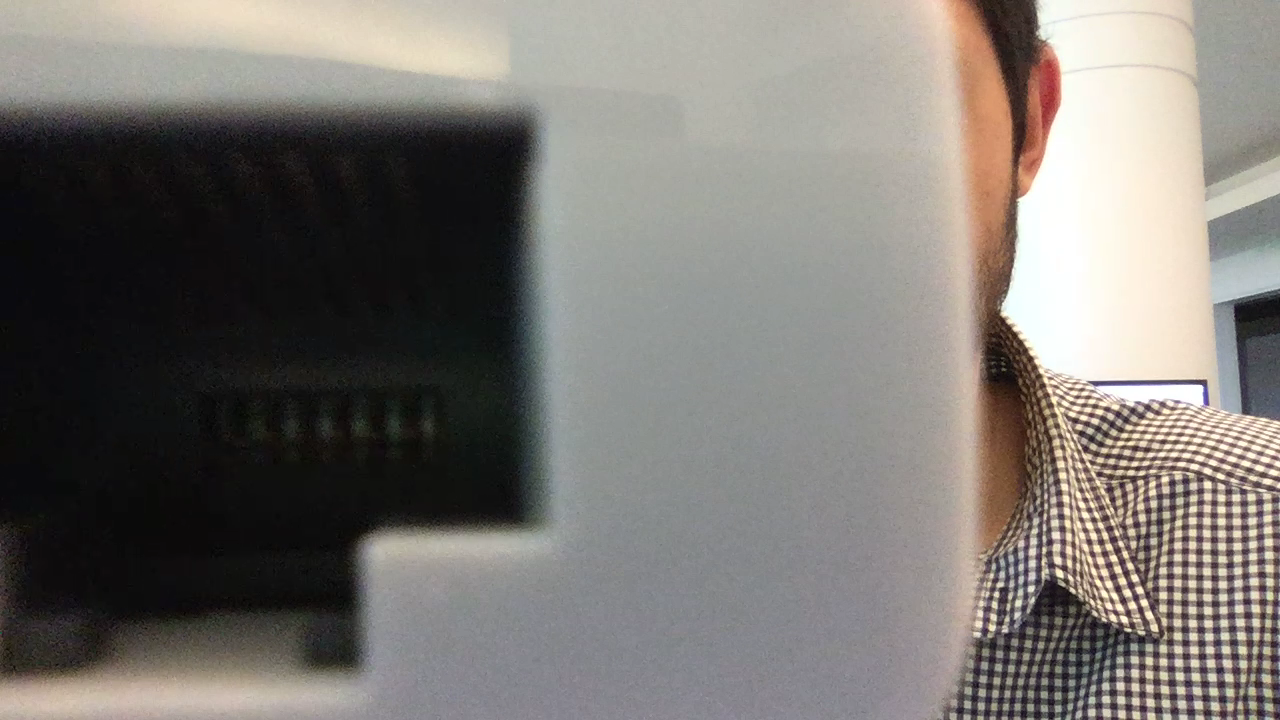

In [138]:
# Show a couple of images
for n in range(2):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))

In [139]:
# Get image labels/classes
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
print(label_names)
label_to_index = dict((name, index) for index,name in enumerate(label_names))
print(label_to_index)
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print('First 10 labels indices: ', all_image_labels[:10])

['ethernet']
{'ethernet': 0}
First 10 labels indices:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Raw image:
<tf.Tensor: id=626, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x00\x00\x00\x02\xd0\x08\x02\x00\x00\x00@\x1fJ\x01\x00\x00 \x00IDATx\x01\x94\xc1K\xb3,Yr\x1d\xe6\xb5\...

Tensor: 
(720, 1280, 3)
<dtype: 'uint8'>

Resized/normalized img:
(192, 192, 3)
0.005637001
1.0


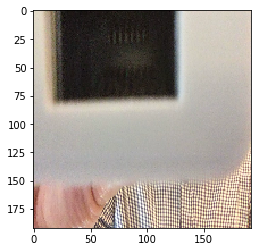

In [140]:
# Load example image
img_path = all_image_paths[0]
img_raw = tf.io.read_file(img_path)
print('Raw image:')
print(repr(img_raw)[:200]+"...\n")
print('Tensor: ')
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)
print('\nResized/normalized img:')
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())
plt.imshow(img_final.numpy())

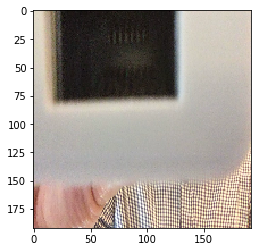

In [141]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))

<TensorSliceDataset shapes: (), types: tf.string>


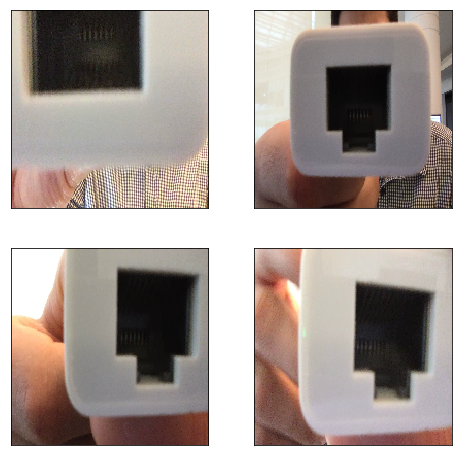

In [146]:
# Image dataset
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print(path_ds)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

In [147]:
# Labels dataset
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
for label in label_ds.take(5):
  print(label_names[label.numpy()])

ethernet
ethernet
ethernet
ethernet
ethernet


In [148]:
# Join them
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [149]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [150]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [151]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 6s 1us/step


In [156]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [157]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [158]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [159]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [160]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -0.24326846
max logit: 2.271776

Shape: (32, 1)


In [161]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [162]:
len(model.trainable_variables)

2

In [163]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [164]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

33.0

In [165]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 24s 8s/step - loss: 0.0000e+00 - accuracy: 0.8750


In [166]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(steps+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
  print("Total time: {}s".format(end-overall_start))

In [167]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [168]:
timeit(ds)

.......
67.0 batches: 36.9834988117218 s
57.97180 Images/s
Total time: 54.99227857589722s


In [169]:
ds = image_label_ds.cache()
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [171]:
save_path = './model2/training/model.h5'
model.save(save_path)